# Time Series 

Time series analysis is an approach to analyze time series data to extract meaningful characteristics of data and generate other useful insights applied in business situation. Generally, time-series data is a sequence of observations stored in time order.

The basic objective of time series analysis usually is to determine a model that describes the pattern of the time series and could be used for forecasting.


### FB Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios.

An additive regression model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects: 

- 1. A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data 
- 2. A yearly seasonal component modeled using Fourier series 
- 3. A weekly seasonal component using dummy variables 
- 4. A user-provided list of important holidays.


Prophet uses a decomposable time series model with these three main model components: trend, seasonality, and holidays.

They are combined in the following equation:

y(t) = g(t) + s(t) + h(t) + e(t)

- g(t) is a trend function which models the non-periodic changes. It can be either a linear function or a logistic function.
- s(t) represents a periodic changes i.e weekly, monthly, yearly. An yearly seasonal component is modeled using Fourier series and weekly seasonal component using dummy variables.
- h(t) is a function that represents the effect of holidays which occur on irregular schedules.(n≥1 days)
- e(t) represents error changes that are not accommodated by the model.

Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken **by exponential smoothing in Holt-Winters technique.** Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

Other Features you can manually tune for your specific situation:
- Set a carrying capacity capto specify the maximum achievable point due to the business scenarios or constraints: market size, total population size, maximum budget, etc.
- A saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum.
- The model could be overfitting or underfitting while working with the trend component. The input of changepoints built in Prophet allowed is increased the fit becomes more flexible. Here, you can nicely apply your business insights: big jump of sales during holidays, cost decreasing in future by purpose and etc. A user can also manually feed the changepoints with those business insights if it is required.

In [52]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
%matplotlib inline


### Milk Data Case Study

In [2]:
#ads = pd.read_csv('/Users/lukeclarke/Documents/BTS_MBDS_2021/projects/time_series/ads.csv', index_col = ['Time'], parse_dates=['Time'])
data = pd.read_csv('/Users/lukeclarke/Documents/BTS_MBDS_2021/projects/time_series/fbprophet/Time_Series_Analysis/milk_production.csv')
data.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [3]:
data.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [4]:
data.drop(168,axis=0,inplace=True)

# Convert time column to datatime
data.Month=pd.to_datetime(data.Month)
data.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
163,1975-08-01,858.0
164,1975-09-01,817.0
165,1975-10-01,827.0
166,1975-11-01,797.0
167,1975-12-01,843.0


In [5]:
# Prophet requires the proper name convention for the columns of the dataset.
data.columns=['ds','y']
data.head()

,ds,y
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [6]:
data.shape

(168, 2)

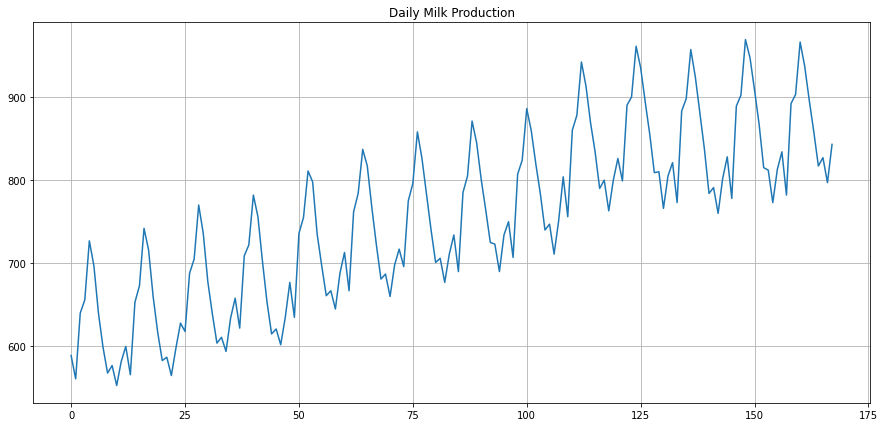

In [7]:
# Plotting Ad Data

plt.figure(figsize=(15, 7))
plt.plot(data.y)
plt.title('Daily Milk Production')
plt.grid(True)
plt.show()

Split data set into training set and test set. Here we would like to use training data set to predict next 30 days ad spend.

Let’s try first model by itself without giving any parameters.

In [8]:
#‘interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast.

model = Prophet(interval_width=0.95)      # By default it is %80

data_train,data_test=data.iloc[:100,:].copy(),data.iloc[100:,:]

print('Train Data', data_train.shape)
print('Test Data', data_test.shape)

Train Data (100, 2)
Test Data (68, 2)


In [9]:
model.fit(data_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = model.make_future_dataframe(periods=68, freq='M') # Predicting the next 68 days, test data
forecast = model.predict(future)

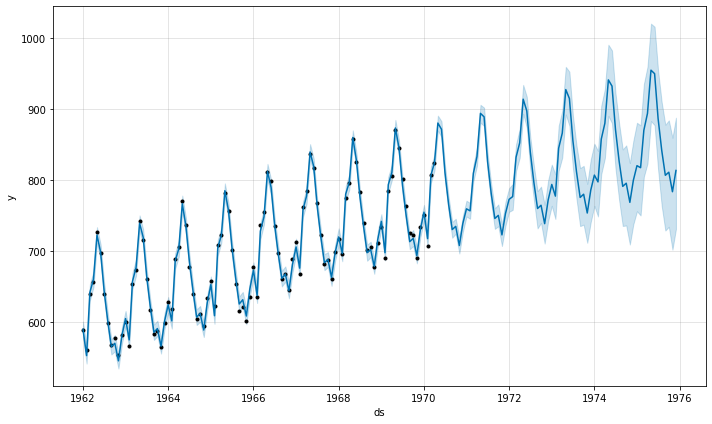

In [11]:
# You can see here the model fails as it is unable to capture the seasonality as they are automatically set to false
# So, we need answer these business questions about our data in the next attempt

forecast_plot=model.plot(forecast)

Train Data (100, 2)
Test Data (68, 2)


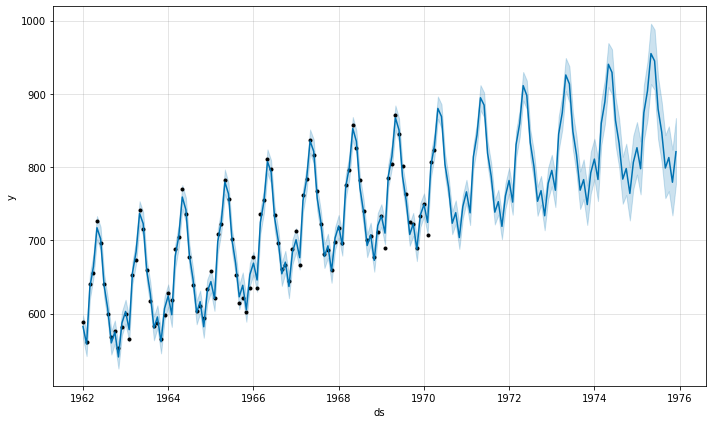

In [12]:
#‘interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast.


better_model = Prophet(daily_seasonality=True,
                       weekly_seasonality=False,
                       yearly_seasonality=False,
                       interval_width=0.95).add_seasonality(name='yearly', period=365.25, fourier_order=5)
                       

data_train, data_test = data.iloc[:100,:].copy() , data.iloc[100:, :]

print('Train Data', data_train.shape)
print('Test Data', data_test.shape)

better_model.fit(data_train)

future = better_model.make_future_dataframe(periods=68, freq='M') # Test Data Count
forecast = better_model.predict(future)

better_forecast_plot=better_model.plot(forecast)

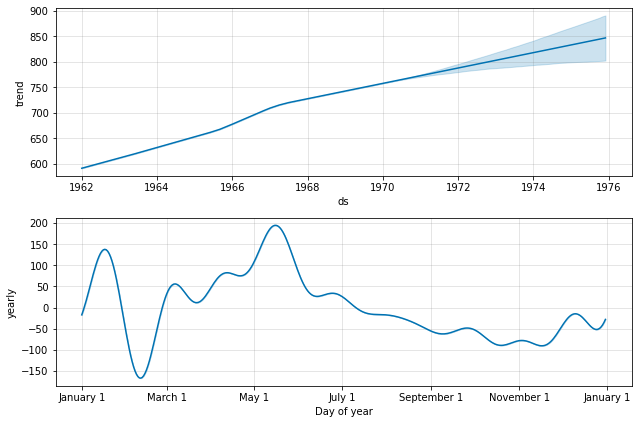

In [13]:
fig = model.plot_components(forecast)

### Stock Data Case Study 

Notice there are NAN values which FB prophet can handle

In [14]:
data = pd.read_csv('/Users/lukeclarke/Documents/BTS_MBDS_2021/projects/time_series/fbprophet/Time_Series_Analysis/data.csv')
data.head()

,Unnamed: 0,Date,open,high,low,close,vol,RSI,MACD,CCI,ADX
0,0,2012-01-01,873.0,879.0,851.0,879.0,799,NaN,0.000000,NaN,NaN
1,1,2012-01-02,879.0,913.0,882.0,900.0,1002,100.000000,0.471154,66.666667,100.000000
2,2,2012-01-03,900.0,916.0,892.0,892.0,2653,70.909091,0.352264,54.237288,100.000000
3,3,2012-01-04,892.0,875.0,842.0,865.0,490,34.466349,-0.685267,-84.313725,67.623618
4,4,2012-01-05,865.0,875.0,858.0,858.0,121,30.141309,-1.513166,-59.581320,52.310464


In [15]:
# We want to predict the closing price - daily data
data=data[['Date','close']]
data.columns=['ds','y']
data.ds=pd.to_datetime(data.ds)
data.head()

,ds,y
0,2012-01-01,879.0
1,2012-01-02,900.0
2,2012-01-03,892.0
3,2012-01-04,865.0
4,2012-01-05,858.0


In [16]:
data.shape

(1910, 2)

In [17]:
data.isna().sum()

ds    0
y     0
dtype: int64

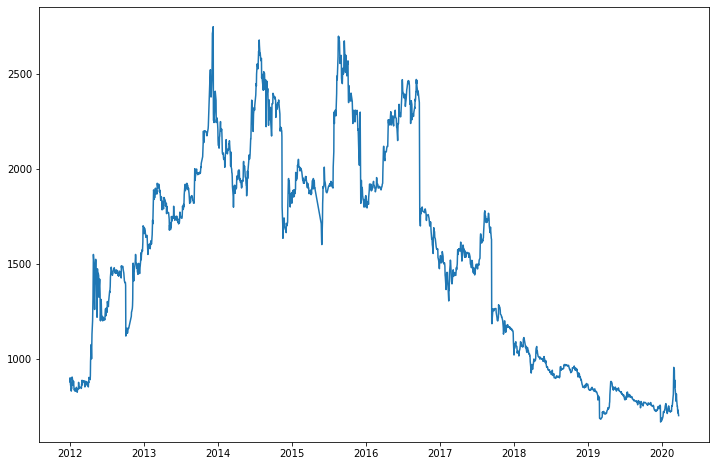

In [18]:
# Plotting the daily stock trend 

plt.figure(figsize=(12,8))
plt.plot(data.set_index(['ds']))

There is a lot noise so lets smooth it by resampling it in weekly data

In [19]:
data.set_index(['ds'],inplace=True)
data.y=data.y.resample("W").mean()
data.dropna(inplace=True)
data.head(10)


,y
ds,
2012-01-01,879.000000
2012-01-08,869.000000
2012-01-22,864.500000
2012-01-29,833.750000
2012-02-05,838.250000
2012-02-12,835.600000
2012-02-26,848.000000
2012-03-04,867.200000
2012-03-11,883.333333


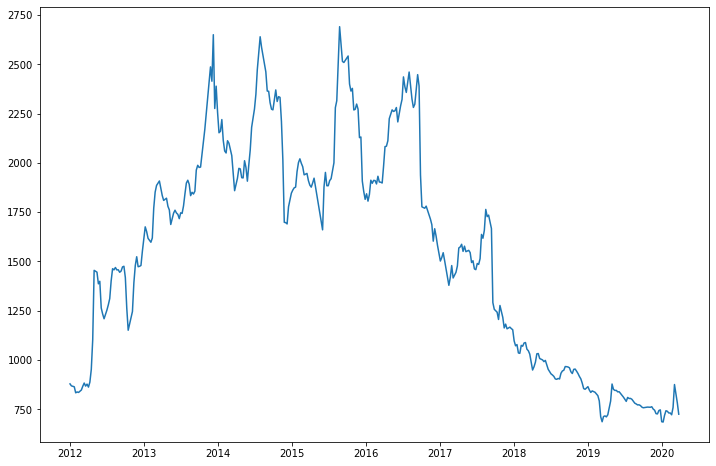

In [20]:
plt.figure(figsize=(12,8))
plt.plot(data)

In [21]:
data['ds']=data.index
data.head()

,y,ds
ds,,
2012-01-01,879.00,2012-01-01
2012-01-08,869.00,2012-01-08
2012-01-22,864.50,2012-01-22
2012-01-29,833.75,2012-01-29
2012-02-05,838.25,2012-02-05


In [22]:
data.shape

(379, 2)

In [23]:
#Prophet model
model=Prophet(n_changepoints=35,
              yearly_seasonality=False,
              weekly_seasonality=False,
              daily_seasonality=False,
              changepoint_prior_scale=0.4).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=10)

In [24]:
model.fit(data)

### Inference

In [25]:
future=model.make_future_dataframe(periods=79,freq="W")
forecast=model.predict(future)

In [26]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,903.366792,629.889219,983.104865,903.366792,903.366792,-95.403952,-95.403952,-95.403952,-95.403952,-95.403952,-95.403952,0.0,0.0,0.0,807.962840
1,2012-01-08,916.639683,650.373135,990.230366,916.639683,916.639683,-90.619781,-90.619781,-90.619781,-90.619781,-90.619781,-90.619781,0.0,0.0,0.0,826.019902
2,2012-01-22,943.185465,667.221296,1029.559315,943.185465,943.185465,-90.861603,-90.861603,-90.861603,-90.861603,-90.861603,-90.861603,0.0,0.0,0.0,852.323862
3,2012-01-29,956.458356,677.883368,1028.344298,956.458356,956.458356,-97.931426,-97.931426,-97.931426,-97.931426,-97.931426,-97.931426,0.0,0.0,0.0,858.526931
4,2012-02-05,969.731248,688.121350,1041.594352,969.731248,969.731248,-97.608506,-97.608506,-97.608506,-97.608506,-97.608506,-97.608506,0.0,0.0,0.0,872.122742


In [27]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
452,2021-08-29,630.610696,329.038486,1196.261987,201.614439,1006.371895,163.296994,163.296994,163.296994,163.296994,163.296994,163.296994,0.0,0.0,0.0,793.907691
453,2021-09-05,629.057732,301.258387,1220.523457,188.671307,1010.157272,162.643376,162.643376,162.643376,162.643376,162.643376,162.643376,0.0,0.0,0.0,791.701109
454,2021-09-12,627.504769,303.875295,1207.870697,175.717115,1014.686135,142.025511,142.025511,142.025511,142.025511,142.025511,142.025511,0.0,0.0,0.0,769.530280
455,2021-09-19,625.951805,222.255919,1163.022427,162.798125,1022.332267,97.431849,97.431849,97.431849,97.431849,97.431849,97.431849,0.0,0.0,0.0,723.383654
456,2021-09-26,624.398842,167.058418,1112.297975,154.300902,1028.550447,46.184816,46.184816,46.184816,46.184816,46.184816,46.184816,0.0,0.0,0.0,670.583658


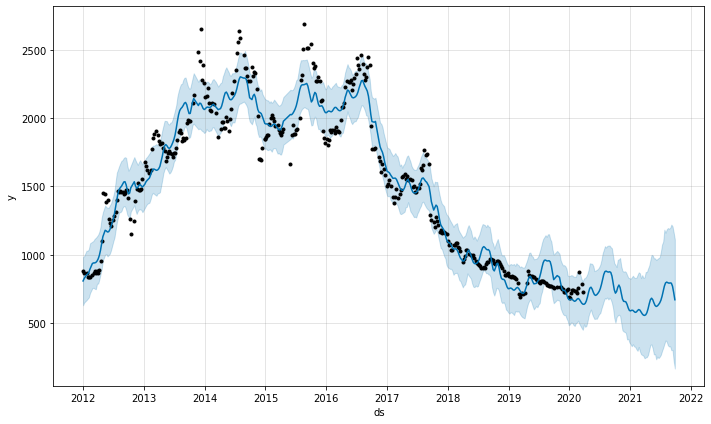

In [28]:
fig=model.plot(forecast) #The model seems to fit well with our data


### Graphs Below Give Good Insights Into The Data

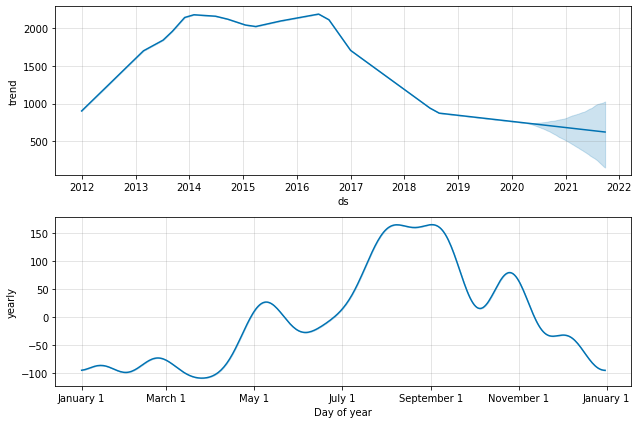

In [29]:
fig2=model.plot_components(forecast)

# Now lets divide the data into a training and test set and evaluate the models performance 

In [30]:
data_train=data.iloc[:300].copy()
data_train.tail()

,y,ds
ds,,
2018-07-08,924.2,2018-07-08
2018-07-15,917.0,2018-07-15
2018-07-22,904.2,2018-07-22
2018-07-29,902.2,2018-07-29
2018-08-05,906.6,2018-08-05


In [31]:
data_test=data.iloc[300:].copy()
data_test.head()

,y,ds
ds,,
2018-08-12,904.00,2018-08-12
2018-08-19,933.00,2018-08-19
2018-08-26,944.60,2018-08-26
2018-09-02,948.25,2018-09-02
2018-09-09,967.00,2018-09-09


In [32]:
data_test.tail()

,y,ds
ds,,
2020-02-16,722.40,2020-02-16
2020-02-23,759.80,2020-02-23
2020-03-01,875.80,2020-03-01
2020-03-15,782.75,2020-03-15
2020-03-22,725.40,2020-03-22


In [33]:
data_test.shape

(79, 2)

In [34]:
model2=Prophet(n_changepoints=35,
              yearly_seasonality=False,
              weekly_seasonality=False,
              daily_seasonality=False,
              changepoint_prior_scale=0.4).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=10)

In [35]:
model2.fit(data_train)

In [36]:
future=model2.make_future_dataframe(periods=79,freq="W") #test count=79
better_forecast=model.predict(future)

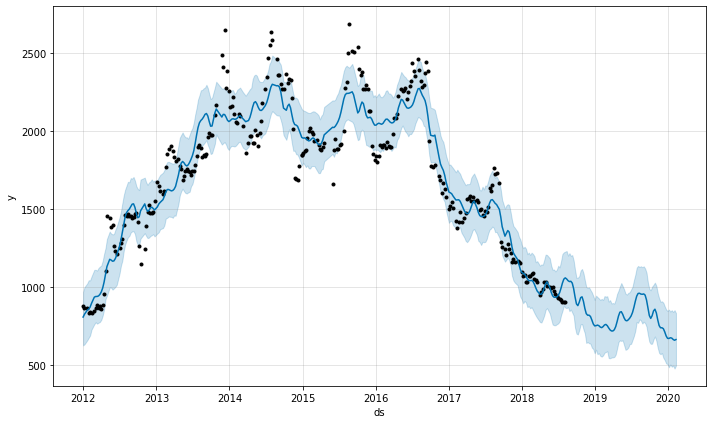

In [37]:
fig3=model2.plot(better_forecast) ##The model worked well for test data, graphs look similar to the original one.

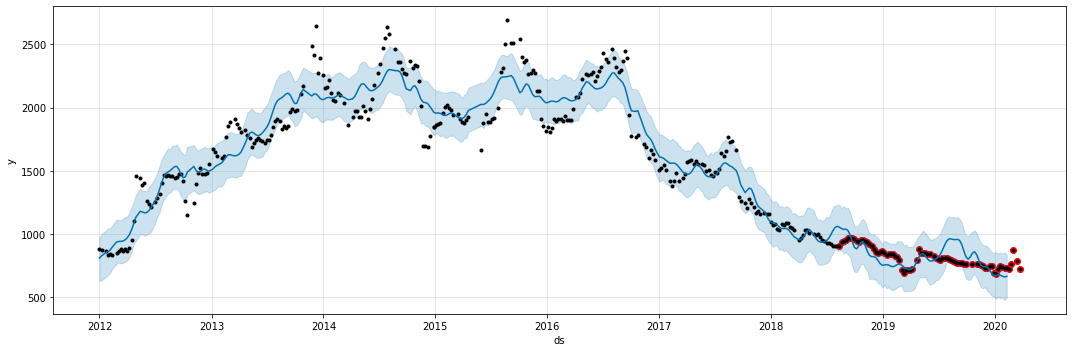

In [38]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['y'], color='r')
fig = model.plot(better_forecast, ax=ax)

In [45]:
better_forecast[-79:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
299,2018-08-12,889.336565,865.107249,1231.734754,889.336565,889.336565,163.249317,163.249317,163.249317,163.249317,163.249317,163.249317,0.0,0.0,0.0,1052.585882
300,2018-08-19,881.881271,872.521285,1202.496117,881.881271,881.881271,159.669769,159.669769,159.669769,159.669769,159.669769,159.669769,0.0,0.0,0.0,1041.551040
301,2018-08-26,874.425977,845.754220,1217.959243,874.425977,874.425977,161.220238,161.220238,161.220238,161.220238,161.220238,161.220238,0.0,0.0,0.0,1035.646216
302,2018-09-02,872.873014,856.150303,1200.720060,872.873014,872.873014,164.543526,164.543526,164.543526,164.543526,164.543526,164.543526,0.0,0.0,0.0,1037.416540
303,2018-09-09,871.320050,836.637677,1205.710464,871.320050,871.320050,154.804556,154.804556,154.804556,154.804556,154.804556,154.804556,0.0,0.0,0.0,1026.124606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2020-01-12,762.612600,504.096519,843.189543,762.612600,762.612600,-87.493753,-87.493753,-87.493753,-87.493753,-87.493753,-87.493753,0.0,0.0,0.0,675.118847
374,2020-01-19,761.059636,489.303849,851.928285,761.059636,761.059636,-88.132658,-88.132658,-88.132658,-88.132658,-88.132658,-88.132658,0.0,0.0,0.0,672.926979
375,2020-01-26,759.506673,496.044256,840.107337,759.506673,759.506673,-95.265641,-95.265641,-95.265641,-95.265641,-95.265641,-95.265641,0.0,0.0,0.0,664.241032
376,2020-02-02,757.953709,477.483264,852.260751,757.953709,757.953709,-99.091361,-99.091361,-99.091361,-99.091361,-99.091361,-99.091361,0.0,0.0,0.0,658.862348


In [49]:
y_true = data_test['y']
y_pred = better_forecast[-79:]['yhat']

In [53]:
mse(y_true, y_pred)

7732.112526930011

In [54]:
mae(y_true, y_pred)

70.9041922514342

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true, y_pred)

8.765439552132753